Install additional packages

In [1]:
!pip install python-gdcm
!pip install pydicom

     |████████████████████████████████| 12.6 MB 8.5 MB/s 
     |████████████████████████████████| 2.0 MB 7.6 MB/s 


Import needed packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.ndimage
from skimage import measure, morphology
from sklearn.cluster import KMeans
import cv2
import pydicom
import matplotlib.pyplot as plt

import seaborn as sns
import gdcm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# About data
Medical dataset containing lungs CT scans of patients diagnosed with pulmonary fibrosis a disorder with no known cause and no known cure, created by scarring of the lungs. Prognosis of the troubling disease becomes frightening for the patients because outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. This is where data science can help in predicting the detoriating condition of the patients. Detailed description about data is found [here.](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data)

## Coordinate Systems in medical imaging

Coordinate system is used for identifying the location of a point. Three types coordinate systems commonly used in imaging applications: the world, anatomical and the medical image coordinate system.

We will talk about Anatomical coordinate system. This system has three planes and **dataset we will be using is on Axial Plane.**

* Axial plane -  The axial plane is actually when you place point of view above the patient and look down. Depending on the region of the 3D medical image you will observe different anatomical structures. For a 3D total body scan, if you had a control-bar over this 2D view you would start from a 2D slice of the head, and by increasing you would end up in the legs. Let’s practically call this view the “drone plane” or “top-view”. Slices near to head is known as superior and towards feet is known as inferior. Below is axial plane of lungs CT Scans.

* Sagittal plane - Basically, this is a side view. Instead of looking from above the patient, now we look from the side. The side can be either right or left. Which side and direction is the positive one, depends on the coordinate system.

* Coronal plane – In this point of view is either in front of eyes(anterior plane) or back of the patient(posterior plane)

Download sample of 1 patient:

In [5]:
!wget "https://raw.githubusercontent.com/chmdznr/ml_image_potekkes/main/data/osic_pulmo_test/ID00419637202311204720264.zip"
!unzip ID00419637202311204720264.zip

--2022-04-04 22:32:08--  https://raw.githubusercontent.com/chmdznr/ml_image_potekkes/main/data/osic_pulmo_test/ID00419637202311204720264.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8598282 (8.2M) [application/zip]
Saving to: ‘ID00419637202311204720264.zip’

ID00419637202311204 100%[===================>]   8.20M  --.-KB/s    in 0.06s   

2022-04-04 22:32:08 (126 MB/s) - ‘ID00419637202311204720264.zip’ saved [8598282/8598282]

Archive:  ID00419637202311204720264.zip
   creating: ID00419637202311204720264/
  inflating: ID00419637202311204720264/1.dcm  
  inflating: ID00419637202311204720264/10.dcm  
  inflating: ID00419637202311204720264/11.dcm  
  inflating: ID00419637202311204720264/12.dcm  
  inflating: ID00419637202311204720264/13.dcm  
  inflating:

# What is DICOM?

A DICOM image file is an outcome of the Digital Imaging and Communications in Medicine standard and represented as .dcm. Because of its ease of integration and continuous evolution this communication standard has over the years achieved a nearly universal level of acceptance among vendors of radiological equipment.DICOM differs from other image formats because it groups information into datasets. DICOM file consist of header and image data collectively in one file. We will see later how these group of information looks like and interpreted.
Detailed information about DICOM can be read [here.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3354356/)

Function to load all slices of patient's DICOM data

In [6]:
## In this dataset ImagePosition is not available so we will sort the slices on InstanceNumber.
def load_slices(path):
    filenames = os.listdir(path)
    slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
    return slices

Load slice and read the DICOM data

In [8]:
scans = load_slices('./ID00419637202311204720264')
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.31565418253559747564938363491048548195
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.31565418253559747564938363491048548195
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

# Conversion to Hounsfield Units
The Hounsfield scale is a quantitative scale for describing radiodensity in medical CT scan and provides an accurate density for the type of tissue. Plain x-rays which only displays 5 densities (i.e. air/fat/soft tissue/bone/metal), CT displays a huge range of densities ranging from air (black) to bone (white). On the Hounsfield scale, water represented by 0 value, air is represented by a value of −1000 (black on the grey scale) and bone between +700 (cancellous bone) to +3000 (dense bone) (white on the grey scale). As bones are much denser than surrounding soft tissues, they show up very clearly in CT images. Raw pixel values of images gets convereted into Hounsfield Units because the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable.
Read more about Hounsfield units on [Hounsfield Scale](https://www.sciencedirect.com/topics/medicine-and-dentistry/hounsfield-scale)

In [9]:
# Rescale intercept, (0028|1052), and rescale slope (0028|1053) are DICOM tags that specify the linear 
# transformation from pixels in their stored on disk representation to their in memory representation.
# Whenever the values stored in each voxel have to be scaled to different units, 
# Dicom makes use of a scale factor using two fields into the header 
# defining the slope and the intercept of the linear transformation to be used to 
# convert pixel values to real world values.

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Histogram Analysis
Lets plot histogram for image pixels after converting to HU and raw pixel values. After converting to HU we can see there is lot of air(-1000) in the scan. Some fat and muscle is also seen.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'HU unit distributions for 10 examples')

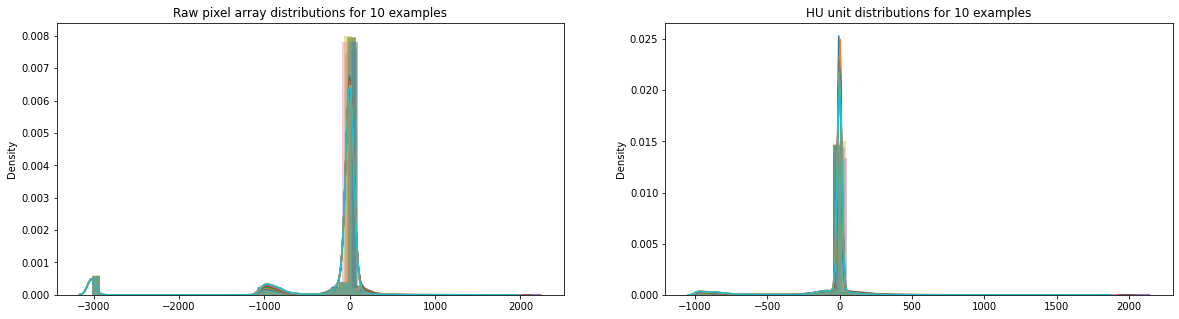

In [10]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
scans = load_slices('./ID00419637202311204720264')
rescaled_images=get_pixels_hu(scans)
images = [scan.pixel_array for scan in scans]
for i in range(10):
    sns.distplot(images[i].flatten(), ax=ax[0])
    sns.distplot(rescaled_images[i].flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples")

In [11]:
scans1 = load_slices("./ID00419637202311204720264")

In [12]:
patient1_hu_scans = get_pixels_hu(scans1)

<a id="resample"></a>
# Resampling
Voxel size resampling is an appropriate preprocessing step for image data sets acquired with variable voxel sizes in order to obtain more reproducible CT features. We found that some of radiomics features were voxel size and gray level discretization dependent. The introduction of normalizing factors in their definitions greatly reduced or removed these dependencies. In computed tomography, voxel size in a region of interest depends on both pixel dimensions (x-y plane) and slice thickness (z-axis), assuming slice thickness equals interslice distance. Any change in these two parameters changes CT image resolution or voxel size. A minimally curation step may be to resample image sets so that all have the same voxel size. In this paper, voxel size resampling was investigated as a way to minimize the variability in feature values due to differing voxel sizes.

Voxel intensities within a region of interest (ROI) are typically resampled into a limited number of discrete values or bin sizes before calculating feature values. Different studies have used different gray level resampling before extracting texture features. Later normalization is also done to improve robustness of these features.


In [24]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image, new_spacing

In [26]:
image1, rounded_new_spacing1 = resample(patient1_hu_scans, scans1, [1,1,1])
print(f"Original shape : {patient1_hu_scans.shape}")
print(f"Shape after resampling : {image1.shape}")

Original shape : (28, 1100, 888)
Shape after resampling : (35, 902, 728)


# Segmentation

Segmentation is most important part of medical image processing as it extracts region of interest. Segmentation defines narrowly what algorithm want to look at, so definitely CNN will perform better on segmented images rather than on whole chest image.
Segmentation is done by many ways and clustering is most common among all. Clustering has several techniques such as K-means clustering, hierarchical clustering, divisive clustering, and mean shift clustering. Moreover, due to the irregular and fuzzy borders in most of the medical images, fuzzy set and neutrosophic set theories become important in the segmentation process to handle uncertainty in the medical images. Read more about medical image segmentation [here.](https://www.sciencedirect.com/topics/engineering/medical-image-segmentation)
After clustering images are morphed using erosion(contraction) and dialation(expansion) to remove unwanted border areas and label different reasons separately. So the steps goes as:
1. Normalization of image.
2. Clustering for separating lung with everything else. (using KMeans)
3. Threshold image.
4. Morphology - Erosion followed by dialation.
5. Label different regions and define regions with different colors.
6. Create lung mask.
7. Apply mask on original image and get final masked image.

In [15]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    # Threshold the image and the output will be a binary image. Morphology workes either on binary or gray images.
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

Visualization of step-by-step lung mask creation

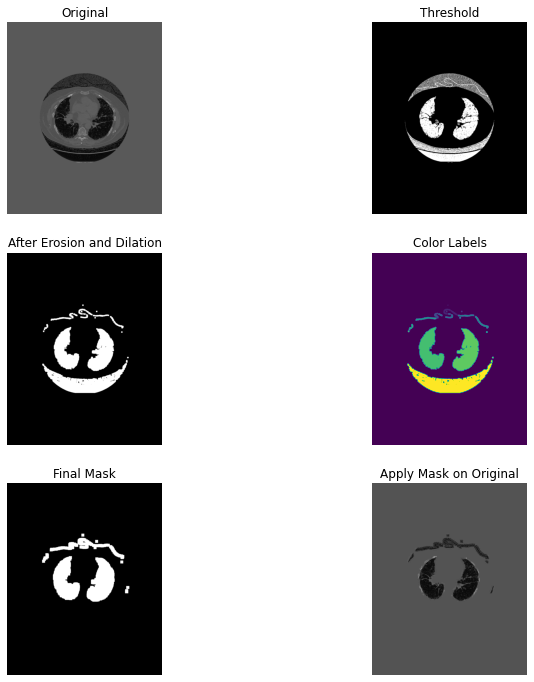

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
make_lungmask(patient1_hu_scans[10], True)

In [20]:
def get_rows_cols(size):
    cols = 6
    rows = size // cols
    if (int(size%cols) != 0):
        rows = rows+1
    return rows,cols

In [21]:
def plot_stack(stack, start_with=10, show_every=3):
    size = (len(stack) - (start_with - 1))//show_every
    rows, cols = get_rows_cols(size)
    plt.tight_layout()
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(size-1):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

Let's plot all of patient's (resampled)-DICOM slices

<Figure size 432x288 with 0 Axes>

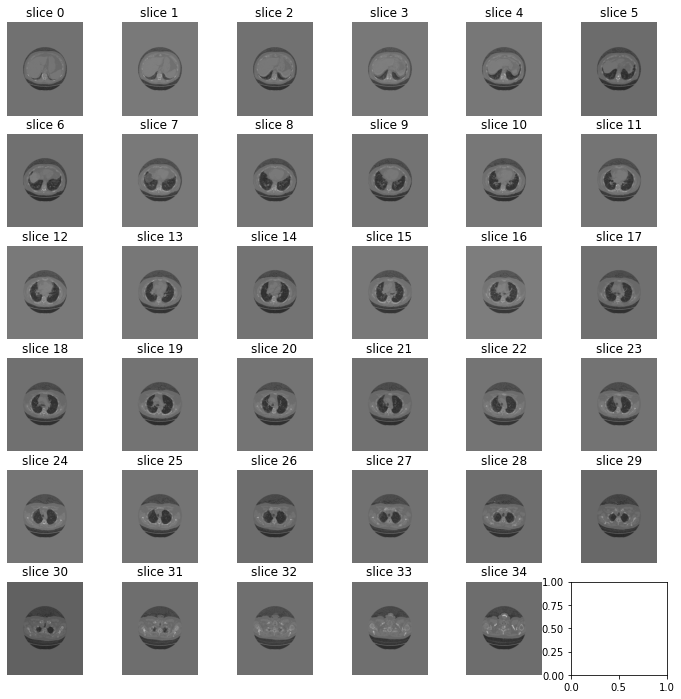

In [27]:
plot_stack(image1, start_with=0, show_every=1)


Let's plot all masks created by our algorithm

<Figure size 432x288 with 0 Axes>

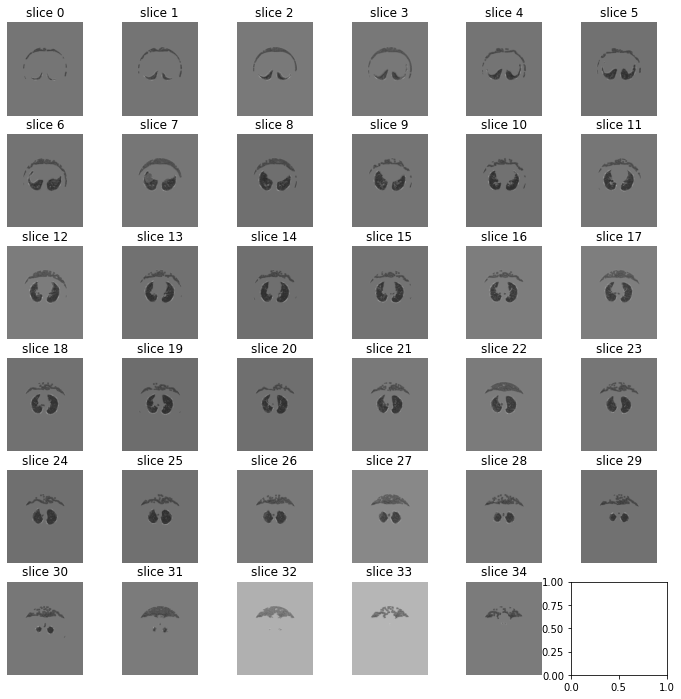

In [28]:
masked_lung = []

for img in image1:
    masked_lung.append(make_lungmask(img))
    
plot_stack(masked_lung, start_with=0, show_every=1)